In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
import torchvision.transforms as transforms
import torchvision.models as models

In [202]:
# loading the pretrained model of Vgg_16 which uses batch_normalization
net = models.vgg16_bn(pretrained=True)

# set the load_path for all image file
load_path = './images/'

# set the save_path for the extracted features file for all the classes
save_path = './Feature_extraction_2D/'
#os.mkdir(save_path)
os.makedirs(save_path, exist_ok=True)

# will get the names of the files present in the load path
# The training data
get_class_names = os.listdir(load_path)

# for each class file
get_class_names

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /home/subbu/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


['truck.npy', 'plane.npy', 'ship.npy', 'bird.npy', 'horse.npy']

In [ ]:
for i in get_class_names:
    # To save the file with the same name for the extracted features
    new_save_path = save_path + i
    
    # To load the class file
    class_path = load_path + i

    # to load the numpy file
    img = np.load(class_path)

    # To append the extracted features
    arr = []

    # for each image in the class file
    for j in img:   

        # converting the numpy array to tensor
        j = torch.tensor(j)
        
        # reshaping the image to [batch_size,number_of_channel,height,width]
        j = j.view([-1,3,32,32])
        
        # rescaling the image to [1,3,224,224]
        # vgg_net the required input is of size 224*224 and single image so batch size 1 
        j = F.interpolate(j,(224,224))
        
        # Extracting the features from the middle layer of the network
        z = net.features(j)
        
        # Features extracted are of size [1,512,7,7]
        # Taking the average pooling for each channel
        m = F.avg_pool2d(z,(7,7),1,0)
        
        # Now the features are of size [1,512,1,1]
        #reshaping the features to [512] 
        m = m.view([-1]).detach()
        
        # converting it back to numpy array
        m = np.asarray(m)

        # appending to the arr
        arr.append(m)

    arr = np.asarray(arr)
    print(arr.shape)

    # To save the numpy array  
    np.save(new_save_path,arr)

In [81]:
# for pretty plot confusion matrix

from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh
import seaborn as sn
import warnings


def get_new_fig(fn, figsize=[9,9]):
    """ Init graphics """
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()   #Get Current Axis
    ax1.cla() # clear existing plot
    return fig1, ax1
#

def configcell_text_and_colors(array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0):
    """
      config cell text and colors
      and return text elements to add and to dell
      @TODO: use fmt
    """
    text_add = []; text_del = [];
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:,col]
    ccl = len(curr_column)

    #last line  and/or last column
    if(col == (ccl - 1)) or (lin == (ccl - 1)):
        #tots and percents
        if(cell_val != 0):
            if(col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(col == ccl - 1):
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(lin == ccl - 1):
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ['%.2f%%'%(per_ok), '100%'] [per_ok == 100]

        #text to DEL
        text_del.append(oText)

        #text to ADD
        font_prop = fm.FontProperties(weight='bold', size=fz)
        text_kwargs = dict(color='w', ha="center", va="center", gid='sum', fontproperties=font_prop)
        lis_txt = ['%d'%(cell_val), per_ok_s, '%.2f%%'%(per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy(); dic['color'] = 'g'; lis_kwa.append(dic);
        dic = text_kwargs.copy(); dic['color'] = 'r'; lis_kwa.append(dic);
        lis_pos = [(oText._x, oText._y-0.3), (oText._x, oText._y), (oText._x, oText._y+0.3)]
        for i in range(len(lis_txt)):
            newText = dict(x=lis_pos[i][0], y=lis_pos[i][1], text=lis_txt[i], kw=lis_kwa[i])
            #print 'lin: %s, col: %s, newText: %s' %(lin, col, newText)
            text_add.append(newText)
        #print '\n'

        #set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if(col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if(per > 0):
            txt = '%s\n%.2f%%' %(cell_val, per)
        else:
            if(show_null_values == 0):
                txt = ''
            elif(show_null_values == 1):
                txt = '0'
            else:
                txt = '0\n0.0%'
        oText.set_text(txt)

        #main diagonal
        if(col == lin):
            #set color of the textin the diagonal to white
            oText.set_color('w')
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color('r')

    return text_add, text_del
#

def insert_totals(df_cm):
    """ insert total column and line (the last ones) """
    sum_col = []
    for c in df_cm.columns:
        sum_col.append( df_cm[c].sum() )
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append( item_line[1].sum() )
    df_cm['sum_lin'] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc['sum_col'] = sum_col
    #print ('\ndf_cm:\n', df_cm, '\n\b\n')
#

def pretty_plot_confusion_matrix(df_cm,st,annot=True, cmap="Oranges", fmt='.2f', fz=20,
      lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='y'):
    """
      print conf matrix with default layout (like matlab)
      params:
        df_cm          dataframe (pandas) without totals
        annot          print text in each cell
        cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
        fz             fontsize
        lw             linewidth
        pred_val_axis  where to show the prediction values (x or y axis)
                        'col' or 'x': show predicted values in columns (x axis) instead lines
                        'lin' or 'y': show predicted values in lines   (y axis)
    """
    if(pred_val_axis in ('col', 'x')):
        xlbl = 'Predicted'
        ylbl = 'Actual'
    else:
        xlbl = 'Actual'
        ylbl = 'Predicted'
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    #this is for print allways in the same window
    fig, ax1 = get_new_fig('Conf matrix default', figsize)

    #thanks for seaborn
    ax = sn.heatmap(df_cm, annot=annot, annot_kws={"size": fz}, linewidths=lw, ax=ax1,
                    cbar=cbar, cmap=cmap, linecolor='w', fmt=fmt)

    #set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize = 15)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 25, fontsize = 15)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    #face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    #iter in text elements
    array_df = np.array( df_cm.to_records(index=False).tolist() )
    text_add = []; text_del = [];
    posi = -1 #from left to right, bottom to top.
    for t in ax.collections[0].axes.texts: #ax.texts:
        pos = np.array( t.get_position()) - [0.5,0.5]
        lin = int(pos[1]); col = int(pos[0]);
        posi += 1
        #print ('>>> pos: %s, posi: %s, val: %s, txt: %s' %(pos, posi, array_df[lin][col], t.get_text()))

        #set text
        txt_res = configcell_text_and_colors(array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values)

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    #remove the old ones
    for item in text_del:
        item.remove()
    #append the new ones
    for item in text_add:
        ax.text(item['x'], item['y'], item['text'], **item['kw'])

    #titles and legends
    ax.set_title('Confusion matrix for'+st)
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    plt.ylim([len(df_cm), -.5])
    plt.tight_layout()  #set layout slim
    plt.show()
#

def plot_confusion_matrix_from_data(y_test,st,predictions, columns=None, annot=True, cmap="Oranges",
      fmt='.2f', fz=20, lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='lin'):
    """
        plot confusion matrix function with y_test (actual values) and predictions (predic),
        whitout a confusion matrix yet
    """
    from sklearn.metrics import confusion_matrix
    from pandas import DataFrame

    #data
    if(not columns):
        #labels axis integer:
        ##columns = range(1, len(np.unique(y_test))+1)
        #labels axis string:
        from string import ascii_uppercase
        columns = ['class %s' %(i) for i in list(ascii_uppercase)[0:len(np.unique(y_test))]]

    confm = confusion_matrix(y_test, predictions)
    cmap = 'Oranges';
    fz = 20;
    figsize=[9,9];
    show_null_values = 2
    df_cm = DataFrame(confm, index=columns, columns=columns)
    pretty_plot_confusion_matrix(df_cm,st,fz=fz, cmap=cmap, figsize=figsize, show_null_values=show_null_values, pred_val_axis=pred_val_axis)
#

def the_plot_conf(test,pred,st):
    """ test function with y_test (actual values) and predictions (predic) """
    #data
    warnings.filterwarnings("ignore")
    y_test = np.array(test)
    predic = np.array(pred)
    """
      Examples to validate output (confusion matrix plot)
        actual: 5 and prediction 1   >>  3
        actual: 2 and prediction 4   >>  1
        actual: 3 and prediction 4   >>  10
    """
    columns = []
    annot = True;
    cmap = 'Oranges';
    fmt = '.2f'
    lw = 0.5
    cbar = False
    show_null_values = 2
    pred_val_axis = 'y'
    #size::
    fz = 20;
    figsize = [9,9];
    if(len(y_test) > 10):
        fz=20; figsize=[14,14];
    plot_confusion_matrix_from_data(y_test," "+st,predic, columns,
      annot, cmap, fmt, fz, lw, cbar, figsize, show_null_values, pred_val_axis)

In [22]:

def sigmoid(x):
  return 1/(1+np.exp(-x))

In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle

In [24]:
path = './Feature_extraction_2D/'
class_names = os.listdir(path)

print(class_names)

['truck.npy', 'plane.npy', 'ship.npy', 'bird.npy', 'horse.npy']


In [25]:
val = 0
data_points = []
data_points_class = []
for i in class_names:
    load_name = os.path.join(path,i)
    extracted_features = np.load(load_name)
    for j in extracted_features:
        data_points.append(j)
        data_points_class.append(val)
    print(val,i)
    val += 1

0 truck.npy
1 plane.npy
2 ship.npy
3 bird.npy
4 horse.npy


In [26]:
temp = list(zip(data_points,data_points_class))
shuffle(temp)

data_points,data_points_class = zip(*temp)
data_points = np.asanyarray(data_points)
data_points_class = np.asanyarray(data_points_class)
print(data_points_class)

[0 2 3 ... 0 2 1]


In [27]:
np.shape(data_points)

(1500, 512)

In [28]:
# setting nodes

dim_hidden_1 = 40
dim_hidden_2 = 28
pca_components = 512
C = 0.01

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data_points, data_points_class,test_size = 0.2)

In [30]:
# from sklearn import decomposition

# pca1 = decomposition.PCA(n_components = pca_components)
# pca1.fit(X_train)
# X_train = pca1.transform(X_train)
# print(X_train.shape)

# pca2 = decomposition.PCA(n_components = pca_components)
# pca2.fit(X_test)
# X_test = pca2.transform(X_test)
# print(X_test.shape)

In [31]:
ytrain = Y_train
b = np.zeros((Y_train.size, Y_train.max()+1))
b[np.arange(Y_train.size),Y_train] = 1
Y_train=b
print(Y_train)

[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [189]:
# Random Initialization and Parameters

lam=1
learning_rate=0.0055
learning_Rate=0.0055
num_iterations=25000
delta_cost = 1e-8
beta = 0.9
gamma = 0.99

W1 = np.random.randn(dim_hidden_1,pca_components) * np.sqrt(2/pca_components)
b1 = np.zeros(shape=(dim_hidden_1, 1))
W2 = np.random.randn(dim_hidden_2, dim_hidden_1) * np.sqrt(2/dim_hidden_1)
b2 = np.zeros(shape=(dim_hidden_2, 1))
W3 = np.random.randn(5, dim_hidden_2) * np.sqrt(2/dim_hidden_2)
b3 = np.zeros(shape=(5, 1))

parameters = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}

In [190]:
opcode = 0

In [191]:
costs=[]
cost = 0
velocity = {"vW1": np.zeros_like(parameters['W1']),
         "vb1": np.zeros_like(parameters['b1']),
         "vW2": np.zeros_like(parameters['W2']),
         "vb2": np.zeros_like(parameters['b2']),
         "vW3": np.zeros_like(parameters['W3']),
         "vb3": np.zeros_like(parameters['b3'])
        }

rms_prop = {"vW1": np.zeros_like(parameters['W1']),
         "vb1": np.zeros_like(parameters['b1']),
         "vW2": np.zeros_like(parameters['W2']),
         "vb2": np.zeros_like(parameters['b2']),
         "vW3": np.zeros_like(parameters['W3']),
         "vb3": np.zeros_like(parameters['b3'])
        }

In [192]:
# Training

for i in range(0, num_iterations):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
   
    Z1 = np.dot(W1, X_train.T) + b1
    A1 = np.tanh(Z1)
    
    Z2 = np.dot(W2, A1) + b2
    A2 = np.tanh(Z2)
    
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2,
             "A3": A3,
             "Z3 ":Z3}
# forward prop


    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    m=1200
    lam=0.4
    prev_cost = cost
    logprobs = np.multiply(np.log(A3), Y_train.T) + np.multiply((1 - Y_train.T), np.log(1 - A3))
    cost =( - np.sum(logprobs) / m)+(lam * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3))) / (2 * m))
    cost = float(np.squeeze(cost))
#  cost
    if i % 100 == 0:
        costs.append(cost)
    
    m=1200
   
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']

    A1 = cache['A1']
    A2 = cache['A2']
    A3 = cache['A3']
    
    lam=0.4
    dZ3 = A3 - Y_train.T
    dW3 = (1 / m) * np.dot(dZ3, A2.T)+((lam* W3) / m)
    db3 = (1 / m) * np.sum(dZ3, axis=1, keepdims=True)
    dZ2 = np.multiply(np.dot(W3.T, dZ3), 1 - np.power(A2, 2))
    dW2 = (1 / m) * np.dot(dZ2, A1.T)+((lam * W2) / m)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.multiply(np.dot(W2.T, dZ2), 1 - np.power(A1, 2))
    dW1 = (1 / m) * np.dot(dZ1, X_train)+(lam * W1) / m
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2,
             "dW3": dW3,
             "db3": db3
            }
# back prop

    if(opcode == 0):
        W1 = parameters['W1']
        b1 = parameters['b1']
        W2 = parameters['W2']
        b2 = parameters['b2']
        W3 = parameters['W3']
        b3 = parameters['b3']
        
        dW1 = grads['dW1']
        db1 = grads['db1']
        dW2 = grads['dW2']
        db2 = grads['db2']
        dW3 = grads['dW3']
        db3 = grads['db3']
        
        W1 = W1 - learning_rate * dW1
        b1 = b1 - learning_rate * db1
        W2 = W2 - learning_rate * dW2
        b2 = b2 - learning_rate * db2
        W3 = W3 - learning_rate * dW3
        b3 = b3 - learning_rate * db3
        
        parameters = {"W1": W1,
                      "b1": b1,
                      "W2": W2,
                      "b2": b2,
                      "W3": W3,
                      "b3": b3
                     }
    else:
        velocity['vW1'] = beta * velocity['vW1'] + (1 - beta) * grads['dW1']
        velocity['vb1'] = beta * velocity['vb1'] + (1 - beta) * grads['db1']
        velocity['vW2'] = beta * velocity['vW2'] + (1 - beta) * grads['dW2']
        velocity['vb2'] = beta * velocity['vb2'] + (1 - beta) * grads['db2']
        velocity['vW3'] = beta * velocity['vW3'] + (1 - beta) * grads['dW3']
        velocity['vb3'] = beta * velocity['vb3'] + (1 - beta) * grads['db3']
        if(opcode == 1):
            W1 = parameters['W1']
            b1 = parameters['b1']
            W2 = parameters['W2']
            b2 = parameters['b2']
            W3 = parameters['W3']
            b3 = parameters['b3']
            
            dW1 = velocity['vW1']
            db1 = velocity['vb1']
            dW2 = velocity['vW2']
            db2 = velocity['vb2']
            dW3 = velocity['vW3']
            db3 = velocity['vb3']
            
            W1 = W1 - learning_rate * dW1
            b1 = b1 - learning_rate * db1
            W2 = W2 - learning_rate * dW2
            b2 = b2 - learning_rate * db2
            W3 = W3 - learning_rate * dW3
            b3 = b3 - learning_rate * db3
            
            parameters = {"W1": W1,
                          "b1": b1,
                          "W2": W2,
                          "b2": b2,
                          "W3": W3,
                          "b3": b3
                         }
            
        else:
            rms_prop['vW1'] = gamma * rms_prop['vW1'] + (1 - gamma) * np.power(grads['dW1'],2)
            rms_prop['vb1'] = gamma * rms_prop['vb1'] + (1 - gamma) * np.power(grads['db1'],2)
            rms_prop['vW2'] = gamma * rms_prop['vW2'] + (1 - gamma) * np.power(grads['dW2'],2)
            rms_prop['vb2'] = gamma * rms_prop['vb2'] + (1 - gamma) * np.power(grads['db2'],2)
            rms_prop['vW3'] = gamma * rms_prop['vW3'] + (1 - gamma) * np.power(grads['dW3'],2)
            rms_prop['vb3'] = gamma * rms_prop['vb3'] + (1 - gamma) * np.power(grads['db3'],2)

            E = 1e-08

            v_correct = {"vW1": np.zeros_like(parameters['W1']),
            "vb1": np.zeros_like(parameters['b1']),
            "vW2": np.zeros_like(parameters['W2']),
            "vb2": np.zeros_like(parameters['b2']),
            "vW3": np.zeros_like(parameters['W3']),
            "vb3": np.zeros_like(parameters['b3'])
            }

            s_correct = {"vW1": np.zeros_like(parameters['W1']),
            "vb1": np.zeros_like(parameters['b1']),
            "vW2": np.zeros_like(parameters['W2']),
            "vb2": np.zeros_like(parameters['b2']),
            "vW3": np.zeros_like(parameters['W3']),
            "vb3": np.zeros_like(parameters['b3'])
            }


            v_correct['vW1'] = velocity['vW1']/(1 - np.power(beta,(i+1)))
            v_correct['vb1'] = velocity['vb1']/(1 - np.power(beta,(i+1)))
            v_correct['vW2'] = velocity['vW2']/(1 - np.power(beta,(i+1)))
            v_correct['vb2'] = velocity['vb2']/(1 - np.power(beta,(i+1)))
            v_correct['vW3'] = velocity['vW3']/(1 - np.power(beta,(i+1)))
            v_correct['vb3'] = velocity['vb3']/(1 - np.power(beta,(i+1)))

            s_correct['vW1'] = rms_prop['vW1']/(1 - np.power(gamma,(i+1)))
            s_correct['vb1'] = rms_prop['vb1']/(1 - np.power(gamma,(i+1)))
            s_correct['vW2'] = rms_prop['vW2']/(1 - np.power(gamma,(i+1)))
            s_correct['vb2'] = rms_prop['vb2']/(1 - np.power(gamma,(i+1)))
            s_correct['vW3'] = rms_prop['vW3']/(1 - np.power(gamma,(i+1)))
            s_correct['vb3'] = rms_prop['vb3']/(1 - np.power(gamma,(i+1)))
            
            W1 = parameters['W1']
            b1 = parameters['b1']
            W2 = parameters['W2']
            b2 = parameters['b2']
            W3 = parameters['W3']
            b3 = parameters['b3']
            
            dW1 = v_correct['vW1'] / np.sqrt(s_correct['vW1'] + E)
            db1 = v_correct['vb1'] / np.sqrt(s_correct['vb1'] + E)
            dW2 = v_correct['vW2'] / np.sqrt(s_correct['vW2'] + E)
            db2 = v_correct['vb2'] / np.sqrt(s_correct['vb2'] + E)
            dW3 = v_correct['vW3'] / np.sqrt(s_correct['vW3'] + E)
            db3 = v_correct['vb3'] / np.sqrt(s_correct['vb3'] + E)
            
            W1 = W1 - learning_rate * dW1
            b1 = b1 - learning_rate * db1
            W2 = W2 - learning_rate * dW2
            b2 = b2 - learning_rate * db2
            W3 = W3 - learning_rate * dW3
            b3 = b3 - learning_rate * db3
            
            parameters = {"W1": W1,
                          "b1": b1,
                          "W2": W2,
                          "b2": b2,
                          "W3": W3,
                          "b3": b3
                         }
            
    if(i%1000==0):
        print("cost ",cost)
        
    if(abs(prev_cost-cost) < delta_cost):
        break
        

cost  3.4926386688025293
cost  2.522654180136124
cost  2.51887505543311
cost  2.514771275333516
cost  2.5100444730571256
cost  2.5044014114202553
cost  2.4975731651579087
cost  2.489256592799788
cost  2.4790389055141047
cost  2.4663644288153095
cost  2.450532154502347
cost  2.430723919532804
cost  2.406089657409429
cost  2.375908008726651
cost  2.339791860255904
cost  2.297822625641134
cost  2.250490116107021
cost  2.1984985203885588
cost  2.1426654659226
cost  2.083973550812286
cost  2.0235797457853333
cost  2.020178183673762
cost  1.9621122455911575
cost  1.9095928925290324
cost  1.8586898319172545


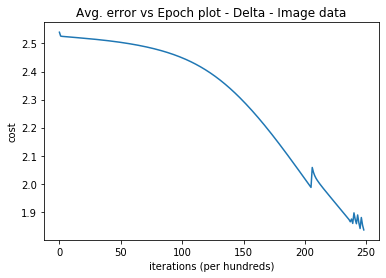

In [199]:
# Avg. error vs Epoch plot

plt.plot(costs[1:])
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Avg. error vs Epoch plot - Delta - Image data")
plt.show()

In [194]:
# Working on training data

W1 = parameters['W1']
b1 = parameters['b1']
W2 = parameters['W2']
b2 = parameters['b2']
W3 = parameters['W3']
b3 = parameters['b3']



Z1 = np.dot(W1, X_train.T) + b1
A1 = np.tanh(Z1)

Z2 = np.dot(W2, A1) + b2
A2 = np.tanh(Z2)

Z3 = np.dot(W3, A2) + b3
A3 = sigmoid(Z3)



cache = {"Z1": Z1,
         "A1": A1,
         "Z2": Z2,
         "A2": A2,
         "A3": A3,
         "Z3 ":Z3}

pred = np.argmax(A3,axis=0)

In [195]:
# Working on development data

W1 = parameters['W1']
b1 = parameters['b1']
W2 = parameters['W2']
b2 = parameters['b2']
W3 = parameters['W3']
b3 = parameters['b3']



Z1 = np.dot(W1, X_test.T) + b1
A1 = np.tanh(Z1)

Z2 = np.dot(W2, A1) + b2
A2 = np.tanh(Z2)

Z3 = np.dot(W3, A2) + b3
A3 = sigmoid(Z3)



cache = {"Z1": Z1,
         "A1": A1,
         "Z2": Z2,
         "A2": A2,
         "A3": A3,
         "Z3 ":Z3}

pred1= np.argmax(A3,axis=0)

In [196]:
# accuracy scores

count=0
i=0
while i<1200:
    if(pred[i]==ytrain[i]):
        count=count+1
    i=i+1
print("train accuracy =",count/1200)

count=0
i=0
while i<300:
    if(pred1[i]==Y_test[i]):
        count=count+1
    i=i+1
print("test accuracy =",count/300)

train accuracy = 0.5775
test accuracy = 0.30666666666666664


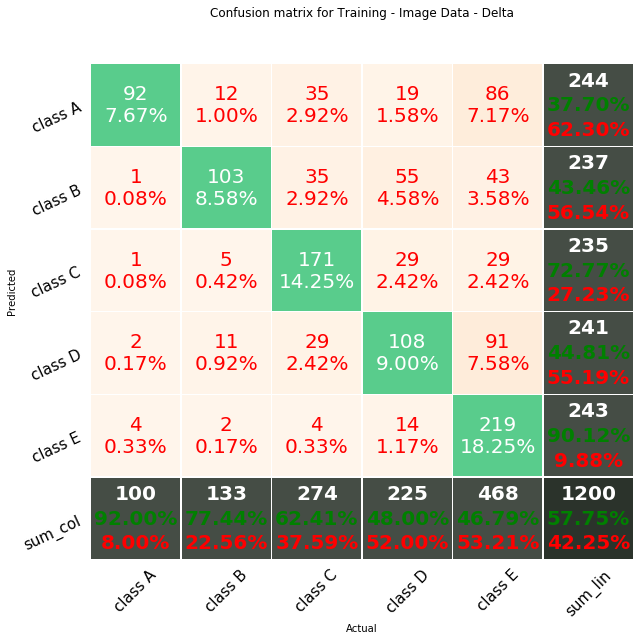

In [200]:
the_plot_conf(pred,ytrain,'Training - Image Data - Delta')

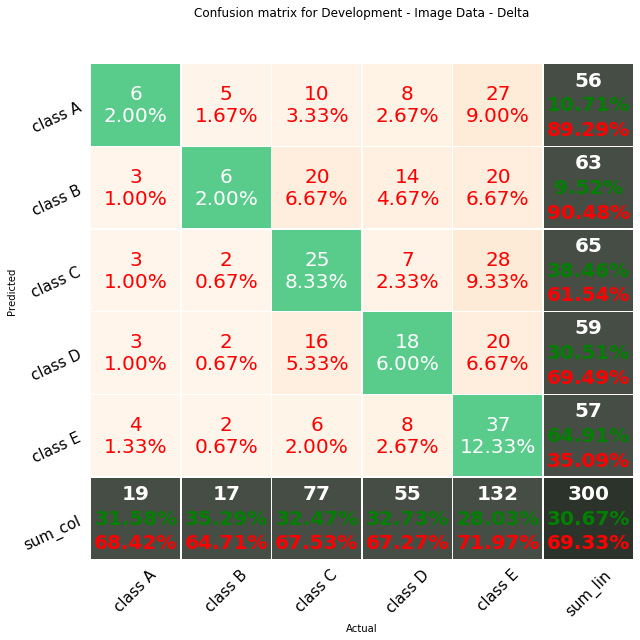

In [201]:
the_plot_conf(pred1,Y_test,'Development - Image Data - Delta')